# [E-14] 폐렴 진단하기

# 목차

Step 1. 실험환경 Set-up

Step 2. 데이터 준비하기

Step 3. 데이터 시각화

Step 4. CNN 모델

Step 5. 데이터 imbalance 처리

Step 6. 모델 훈련

Step 7. 결과 확인과 시각화

# 루브릭&회고

아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.


2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.


3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
	Accuracy 기준 85%에 도달하였다.
    
= 정확도는 아깝게 84가 나왔다 batch사이즈를 늘리거나 seed를 고정하면 정확도가 더 잘나올것 같다. 

= 모델 fit 하는 부분에서 데이터관련 오류가 떠서 int로 바꿔주고 처리했다.

# Step 1. 실험환경 Set-up
 Batch size, Epoch

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)

/home/aiffel-dj54/aiffel


# Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1067
Pneumonia images count in training set: 3118


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/aiffel_exp_data/E-14_exp_data/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == "PNEUMONIA")   # 폐렴이면 양성(True), 노말이면 음

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [12]:
# argumentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [13]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 224, 224, 3)
Label:  [0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1]


In [15]:
#test셋도 동일하게 진행

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/aiffel_exp_data/E-14_exp_data/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


# Step 3. 데이터 시각화

train에 있는 batch 중 첫번째 배치를 추출한다. 
배치안에 있는 img와 label을 나눈다. 

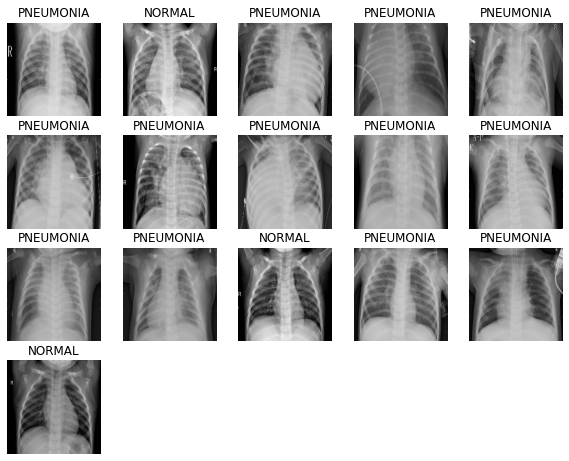

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
Convolution filter, 채널 개수, activation, 모델구조 수정가능

만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다. 


In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

BatchNormalization: 레이어를 통과할때 입력값(w)의 분포가 각자 달라서 기울기 손실, exploding이 발생한다. 그래서 입력값을 일반화 해서 안정적이게 만듬

 입력값 분포를 평균 0, 표준 편차 1인 분포로 만든다.   

# Step 5. 데이터 imbalance 처리
 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요? 
 
 ### 클래스 균형은 소수의 클래스를 예측할때 중요하다.
 소수의 클래스를 예측하는게 더 중요한 문제일때 그 클ㄹ스에 더 큰 비중(가중치)를 두고 정확하게 예측한다.

training set의 데이터에서 loss를 계산할때 특정 클래스에 더 큰 loss값을 갖도록하여 가중치를 부여하는 방법이다.  


In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [21]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

# Step 6. 모델 훈련
optimizer나 learning rate 변경가능

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Train for 261 steps, validate for 65 steps
Epoch 1/15
261/261 [==============================] - 41s 157ms/step - loss: 0.3403 - accuracy: 0.8281 - precision: 0.9657 - recall: 0.7975 - val_loss: 1.0170 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 35s 135ms/step - loss: 0.2009 - accuracy: 0.9227 - precision: 0.9781 - recall: 0.9169 - val_loss: 2.2248 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 35s 132ms/step - loss: 0.1936 - accuracy: 0.9279 - precision: 0.9785 - recall: 0.9234 - val_loss: 1.1173 - val_accuracy: 0.7385 - val_precision: 0.7367 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 35s 135ms/step - loss: 0.1847 - accuracy: 0.9274 - precision: 0.9769 - recall: 0.9245 - val_loss: 0.3218 - val_accuracy: 0.9288 - val_precision: 0.9143 - val_recall: 0.9961
Epoch 5/15
261/261 [=============================

# Step 7. 결과 확인과 시각화
 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

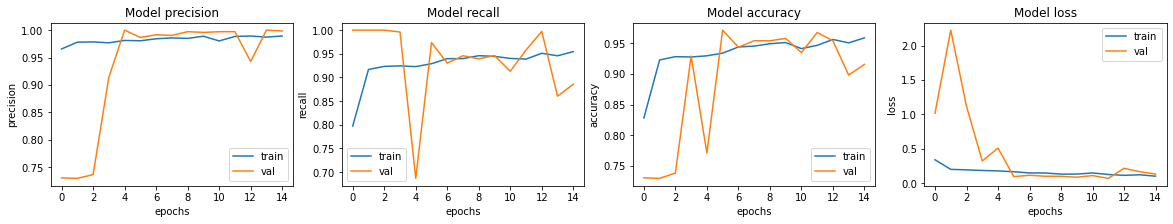

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 77ms/step - loss: 0.4605 - accuracy: 0.8429 - precision: 0.8333 - recall: 0.9359
